In [1]:
import sys
sys.path.append("..")
import src.sim
import src.strategy
import src.clearing
from src.plot import SimulationVisualizer

# Load Profiles

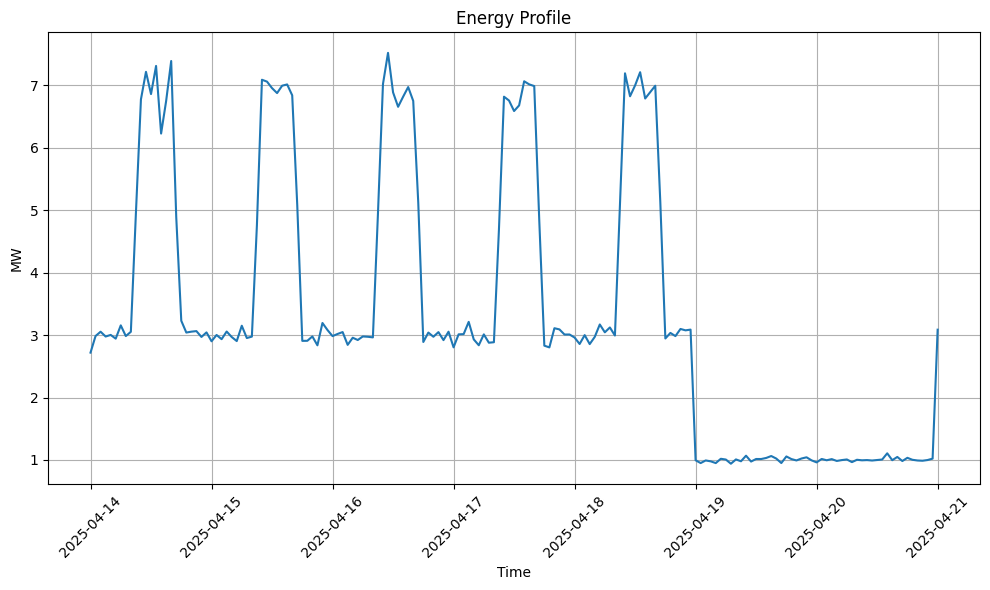

In [2]:
from src.load_profiles import industrial_profile, plot_profile
import datetime

profile = industrial_profile(
    base_load=3, 
    peak_load=7,
    start_time=datetime.datetime(2025, 4, 14, 0, 0),
    end_time=datetime.datetime(2025, 4, 21, 0, 0),
    time_step=datetime.timedelta(minutes=60)
)

plot_profile(profile)

# Data Sources

This implements the DataSource for the day ahead and intraday prices. 

### Day ahead prices

In [3]:
import pandas as pd
import datetime
from typing import Optional, Union
from src.data import DataSource

class DayAheadData(DataSource):
    """Data source for day-ahead electricity prices from SMARD."""
    
    def __init__(self, file_path: str, 
                 start_time: Optional[datetime.datetime] = None,
                 end_time: Optional[datetime.datetime] = None,
                 name: Optional[str] = None):
        """Load day-ahead price data from the CSV file.
        
        Args:
            file_path: Path to the CSV file
            start_time: Optional filter for beginning of data range
            end_time: Optional filter for end of data range
            name: Optional name for this data source
        """
        super().__init__(name or "DayAhead")
        self.file_path = file_path
        
        # Load the CSV file with proper settings for this format
        self.data = pd.read_csv(
            file_path, 
            sep=';',  # Semicolon separator
            parse_dates=['Start date', 'End date'],  # Parse date columns
            date_format="%b %d, %Y %I:%M %p"  # Format like "Apr 14, 2025 12:00 AM"
        )
        
        # Rename columns for easier access
        self.data = self.data.rename(columns={
            'Start date': 'delivery_time',
            'End date': 'end_time',
            'Germany/Luxembourg [€/MWh] Original resolutions': 'price'
        })
        
        # Keep only the relevant columns
        self.data = self.data[['delivery_time', 'end_time', 'price']]
        
        # Filter by date range if provided
        if start_time:
            self.data = self.data[self.data['delivery_time'] >= start_time]
        if end_time:
            self.data = self.data[self.data['delivery_time'] <= end_time]
    
    def get_data(self, delivery_time: datetime.datetime) -> float:
        """Retrieve the price for a specific delivery time.
        
        Args:
            delivery_time: The delivery start time to get the price for
            
        Returns:
            Price for the requested delivery time
            
        Raises:
            ValueError: If no price is found for the delivery time
        """
        # Find the exact matching delivery time
        matching_data = self.data[self.data['delivery_time'] == delivery_time]
        
        if matching_data.empty:
            raise ValueError(f"No price data found for delivery time: {delivery_time}")
        
        # Return the price value
        return matching_data.iloc[0]['price']

### Intraday prices

In [4]:
import pandas as pd
import datetime
import os
import re
from typing import Optional, Dict, Union, List
from src.data import DataSource

class IntradayData(DataSource):
    """Data source for intraday electricity prices.
    
    Handles the specific CSV format with delivery periods and VWAP values.
    Can load data from multiple files.
    """
    
    def __init__(self, file_paths: Union[str, List[str]], 
                 start_time: Optional[datetime.datetime] = None,
                 end_time: Optional[datetime.datetime] = None,
                 name: Optional[str] = None):
        """Load intraday price data from one or more CSV files.
        
        Args:
            file_paths: Path to a single CSV file or list of file paths
            start_time: Optional filter for beginning of data range
            end_time: Optional filter for end of data range
            name: Optional name for this data source
        """
        super().__init__(name or "Intraday")
        
        # Convert single file path to list for consistent processing
        if isinstance(file_paths, str):
            file_paths = [file_paths]
        
        self.file_paths = file_paths
        
        # Process each file and combine the data
        all_data = []
        for file_path in self.file_paths:
            # Extract date from filename
            filename = os.path.basename(file_path)
            date_match = re.search(r'(\d{1,2})\.(\d{1,2})\.(\d{2})', filename)
            
            if not date_match:
                raise ValueError(f"Could not extract date from filename: {filename}")
            
            day, month, year = map(int, date_match.groups())
            # Assuming 20xx for the year
            year += 2000
            delivery_date = datetime.date(year, month, day)
            
            # Load the file
            df = pd.read_csv(
                file_path, 
                sep=';',  # Semicolon separator
                thousands=' ',  # Space as thousands separator
                decimal=',',  # Comma as decimal separator
            )
            
            # Process delivery period with the file's specific date
            df['delivery_time'] = df['Delivery period (CET)'].apply(
                lambda x: self._parse_delivery_period(x, delivery_date)
            )
            
            # Keep only the relevant columns
            columns_to_keep = ['delivery_time', 'VWAP', 'VWAP1H', 'VWAP3H']
            df = df[columns_to_keep]
            
            all_data.append(df)
        
        # Combine all data frames
        self.data = pd.concat(all_data, ignore_index=True)
        
        # Filter by date range if provided
        if start_time:
            self.data = self.data[self.data['delivery_time'] >= start_time]
        if end_time:
            self.data = self.data[self.data['delivery_time'] <= end_time]
    
    def _parse_delivery_period(self, period_str: str, delivery_date: datetime.date) -> datetime.datetime:
        """Parse the delivery period string to extract the delivery time.
        
        Args:
            period_str: String like "00:00 - 01:00"
            delivery_date: Date for this contract
            
        Returns:
            Datetime object for the start of the delivery period
        """
        # Extract the start time from the period (e.g., "00:00" from "00:00 - 01:00")
        start_time_str = period_str.split(' - ')[0]
        hours, minutes = map(int, start_time_str.split(':'))
        
        # Combine with the delivery date
        return datetime.datetime.combine(
            delivery_date, 
            datetime.time(hours, minutes)
        )
    
    def get_data(self, delivery_time: datetime.datetime) -> Dict[str, float]:
        """Retrieve VWAP prices for a specific delivery time.
        
        Args:
            delivery_time: The delivery time to get prices for
            
        Returns:
            Dictionary with VWAP, VWAP1H, and VWAP3H values
            
        Raises:
            ValueError: If no data is found for the delivery time
        """
        # Find the exact matching delivery time
        matching_data = self.data[self.data['delivery_time'] == delivery_time]
        
        if matching_data.empty:
            raise ValueError(f"No intraday data found for delivery time: {delivery_time}")
        
        # Return the VWAP values as a dictionary
        row = matching_data.iloc[0]
        return {
            'VWAP': row['VWAP'],
            'VWAP1H': row['VWAP1H'],
            'VWAP3H': row['VWAP3H']
        }

### Load data

In [5]:
import datetime

prefix = "/Users/salwetingh/code/master/data/"
# Load all data, filtering can be done during initialization
da_prices = DayAheadData(prefix + "Day-ahead_pricesSMARD_202504140000_202504220000_Hour.csv")

# Get price for a specific delivery hour
delivery_time = datetime.datetime(2025, 4, 14, 0, 0)
price = da_prices.get_data(delivery_time)
print(f"Price for {delivery_time}: {price} €/MWh")

# Multiple files example
intraday_data = IntradayData([
    prefix + "intradayvwap/14.4.25.csv",
    prefix + "intradayvwap/15.4.25.csv",
    prefix + "intradayvwap/16.4.25.csv",
    prefix + "intradayvwap/17.4.25.csv",
    prefix + "intradayvwap/18.4.25.csv",
    prefix + "intradayvwap/19.4.25.csv",
    prefix + "intradayvwap/20.4.25.csv",
])

# Get VWAP values for a specific contract
vwap_data = intraday_data.get_data(delivery_time)
print(f"Price for {delivery_time}: {vwap_data['VWAP']} €/MWh")
print(f"Price for {delivery_time}: {vwap_data['VWAP1H']} €/MWh")
print(f"Price for {delivery_time}: {vwap_data['VWAP3H']} €/MWh")


Price for 2025-04-14 00:00:00: 87.56 €/MWh
Price for 2025-04-14 00:00:00: 95.22 €/MWh
Price for 2025-04-14 00:00:00: 103.4 €/MWh
Price for 2025-04-14 00:00:00: 98.22 €/MWh


# Trading Strategy

In [8]:
import datetime
import uuid
import random
from typing import List, Dict, Tuple, Any, Optional
from abc import ABC, abstractmethod
from src.sim import Order
from src.strategy import Strategy
import pandas as pd

class UrgencyBasedStrategyOV(Strategy):
    """Strategy that adjusts prices based on urgency as delivery time approaches.
    
    Places initial orders 6 hours before delivery and updates them periodically.
    Price adjusts from discount to premium as delivery approaches.
    """
    
    def __init__(self, 
                 load_profile: pd.DataFrame,
                 data_source: DataSource,
                 strategy_id: Optional[str] = None,
                 initial_order_time: int = 6,  # Hours before delivery
                 update_interval: int = 90,    # Minutes between updates
                 max_discount: float = 0.45,   # Max discount when far from delivery
                 max_premium: float = 0.20,
                 end_time: datetime.datetime = None):   # Max premium when close to delivery
        """Initialize the urgency-based strategy.
        
        Args:
            load_profile: DataFrame with timestamp and value columns
            data_sources: Optional list of data sources for price information
            strategy_id: Unique identifier for this strategy instance
            initial_order_time: Hours before delivery to place initial orders
            update_interval: Minutes between order updates
            max_discount: Maximum percentage discount for early orders
            max_premium: Maximum percentage premium for urgent orders
        """
        super().__init__(strategy_id=strategy_id, load_profile=load_profile)
        self.strategy_id = strategy_id
        self.data_source = data_source
        self.initial_order_time = initial_order_time
        self.update_interval = update_interval
        self.max_discount = max_discount
        self.max_premium = max_premium
        self.end_time = end_time
        # Track processed deliveries and last update times
        self.processed_deliveries = set()  # Delivery times with initial orders
        self.last_updates = {}  # Mapping of delivery_time -> last_update_time
    
    def update_orders(self, current_time: datetime.datetime) -> Tuple[List, List, List]:
        """Generate trading decisions for the current time step.
        
        Places initial orders at specified time before delivery.
        Updates existing orders periodically with adjusted prices.
        
        Args:
            current_time: Current simulation time
            
        Returns:
            Tuple of (new_orders, updated_orders, canceled_order_ids)
        """
        new_orders = []
        updated_orders = []
        canceled_order_ids = []
        
        # Look for delivery times for initial orders
        initial_look_ahead = current_time + datetime.timedelta(hours=self.initial_order_time)
        
        # 1. Process new initial orders
        if self.load_profile is not None:
            upcoming_deliveries = self.load_profile[
                (self.load_profile['timestamp'] == initial_look_ahead) & 
                (~self.load_profile['timestamp'].isin(self.processed_deliveries))
            ]
            
            for _, row in upcoming_deliveries.iterrows():
                delivery_time = row['timestamp']
                quantity = row['value']

                if self.end_time and delivery_time > self.end_time - datetime.timedelta(hours=1):
                    continue
                
                if quantity > 0:
                    # Calculate initial price with discount
                    base_price = self.get_price(delivery_time)
                    discount_factor = 1.0 - self.max_discount
                    price = base_price * discount_factor
                    
                    # Create initial buy order
                    order = self.create_order(
                        price=price,
                        quantity=quantity,
                        contract_time=delivery_time,
                        side='buy'
                    )
                    new_orders.append(order)
                    
                    # Remember that we've processed this delivery time
                    self.processed_deliveries.add(delivery_time)
                    self.last_updates[delivery_time] = current_time
        
        # 2. Process updates to existing orders
        for order_id, order in self.active_orders.items():
            delivery_time = order.contract_time
            last_update = self.last_updates.get(delivery_time)
            
            # Check if it's time to update this order
            if (last_update and 
                (current_time - last_update).total_seconds() >= self.update_interval * 60):
                
                # Calculate time remaining until delivery
                remaining_time = (delivery_time - current_time).total_seconds() / 3600  # hours
                
                # Calculate urgency factor (0 to 1, where 1 is most urgent)
                # Scale based on remaining time compared to initial order time
                urgency = max(0, 1 - (remaining_time / self.initial_order_time))
                
                # Interpolate between discount and premium based on urgency
                price_adjustment = -self.max_discount + urgency * (self.max_discount + self.max_premium)
                
                # Get base price (using the random range for simplicity, could use data source)
                base_price = self.get_price(delivery_time)
                
                # Apply adjustment
                adjusted_price = base_price * (1.0 + price_adjustment)
                
                # Create updated order with new price
                updated_order = self.create_order(
                    price=adjusted_price,
                    quantity=order.quantity,
                    contract_time=delivery_time,
                    side=order.side
                )
                updated_order.order_id = order_id  # Keep the same ID for updating
                
                updated_orders.append(updated_order)
                self.last_updates[delivery_time] = current_time
        
        return new_orders, updated_orders, canceled_order_ids
    
    def get_price(self, delivery_time: datetime.datetime) -> float:
        """Get the price for a specific delivery time.
        
        Uses intraday price data from the day before (24 hours ago) as the reference.
        Gets prices for delivery_time and +/- 60 minutes around it 24 hours ago,
        then returns the mean of these three prices.
        
        Args:
            delivery_time: The delivery time to get the price for

        Returns:    
            Mean price across the 3-hour window from the previous day
        """
        # Calculate the same time but 24 hours earlier
        day_before_time = delivery_time - datetime.timedelta(days=1)
        before_time = day_before_time - datetime.timedelta(minutes=60)
        after_time = day_before_time + datetime.timedelta(minutes=60)
        
        try:
            # Get data from 24 hours ago
            data_before = self.data_source.get_data(before_time)
            data_at = self.data_source.get_data(day_before_time)
            data_after = self.data_source.get_data(after_time)
            
            price_before = data_before['VWAP'] if not isinstance(data_before, float) else data_before
            price_at = data_at['VWAP'] if not isinstance(data_at, float) else data_at
            price_after = data_after['VWAP'] if not isinstance(data_after, float) else data_after
            return (price_before + price_at + price_after) / 3
        except (ValueError, KeyError) as e:
            # If data from the day before is not available, fall back to current data
            print(f"Warning: No data available for previous day at {day_before_time}, using current time data")
            before_time = delivery_time - datetime.timedelta(minutes=60)
            after_time = delivery_time + datetime.timedelta(minutes=60)
            
            data_before = self.data_source.get_data(before_time)
            data_at = self.data_source.get_data(delivery_time)
            data_after = self.data_source.get_data(after_time)
            
            price_before = data_before['VWAP'] if not isinstance(data_before, float) else data_before
            price_at = data_at['VWAP'] if not isinstance(data_at, float) else data_at
            price_after = data_after['VWAP'] if not isinstance(data_after, float) else data_after
            return price_at


# Clearing Mechanisms

Implement the 3 different clearing mechanisms based on different DataSources.

In [9]:
import datetime
from typing import Dict, List, Any, Optional
from src.data import DataSource
from src.clearing import ClearingMechanism


class ReferenceBasedClearing(ClearingMechanism):
    """Simple clearing mechanism that uses a data source as reference price.
    
    Orders clear if they cross the reference price (buys above, sells below),
    with execution happening at the reference price.
    """
    
    def __init__(self, data_source: DataSource):
        """Initialize the reference-based clearing.
        
        Args:
            data_source: Data source that provides reference prices
        """
        super().__init__()
        self.data_source = data_source
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Clear orders against reference price from data source.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of active orders (order_id -> Order)
            
        Returns:
            List of orders that were filled/executed in this clearing
        """
        cleared_orders = []
        
        # Group orders by delivery time
        orders_by_delivery = {}
        for order_id, order in active_orders.items():
            delivery_time = order.contract_time
            if delivery_time not in orders_by_delivery:
                orders_by_delivery[delivery_time] = []
            orders_by_delivery[delivery_time].append(order)
        
        # Process orders for each delivery time
        for delivery_time, orders in orders_by_delivery.items():
            # Skip processing if delivery time has passed
            if delivery_time < current_time:
                continue
                
            try:
                # Get reference price for this delivery time
                reference_data = self.data_source.get_data(delivery_time)
                
                # Extract the actual price value to use (handle both float and dict returns)
                if isinstance(reference_data, dict):
                    # If it's a dictionary, use the VWAP value
                    reference_price = reference_data['VWAP']
                else:
                    # If it's already a float/number, use it directly
                    reference_price = reference_data
                
                # Check each order against the reference price
                for order in orders:
                    if order.side == 'buy' and order.price >= reference_price:
                        # Buy order clears if price is at or above reference
                        order.executed_price = reference_price
                        order.executed_time = current_time
                        cleared_orders.append(order)
                        
                    elif order.side == 'sell' and order.price <= reference_price:
                        # Sell order clears if price is at or below reference
                        order.executed_price = reference_price
                        order.executed_time = current_time
                        cleared_orders.append(order)
                        
            except (ValueError, KeyError) as e:
                # Handle case where no reference price is available
                print(f"No reference price available for {delivery_time}: {e}")
                continue
        
        return cleared_orders

In [10]:
class TimeHorizonClearing(ClearingMechanism):
    """Clearing mechanism that uses different VWAP references based on time to delivery.
    
    Uses:
    - VWAP for times more than 3 hours from delivery
    - VWAP3H for times between 1-3 hours from delivery
    - VWAP1H for times less than 1 hour from delivery
    """
    
    def __init__(self, data_source: DataSource):
        """Initialize the time-horizon based clearing.
        
        Args:
            data_source: Data source that provides VWAP reference prices
        """
        super().__init__()
        self.data_source = data_source
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Clear orders against appropriate VWAP reference price based on time to delivery.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of active orders (order_id -> Order)
            
        Returns:
            List of orders that were filled/executed in this clearing
        """
        cleared_orders = []
        
        # Group orders by delivery time
        orders_by_delivery = {}
        for order_id, order in active_orders.items():
            delivery_time = order.contract_time
            if delivery_time not in orders_by_delivery:
                orders_by_delivery[delivery_time] = []
            orders_by_delivery[delivery_time].append(order)
        
        # Process orders for each delivery time
        for delivery_time, orders in orders_by_delivery.items():
            # Skip processing if delivery time has passed
            if delivery_time < current_time:
                continue
                
            try:
                # Calculate time to delivery in hours
                time_to_delivery = (delivery_time - current_time).total_seconds() / 3600
                
                # Get reference data for this delivery time
                reference_data = self.data_source.get_data(delivery_time)
                
                # Select the appropriate VWAP based on time to delivery
                if time_to_delivery <= 1:
                    # Last hour before delivery
                    reference_price = reference_data['VWAP1H']
                elif time_to_delivery <= 3:
                    # Between 1 and 3 hours before delivery
                    reference_price = reference_data['VWAP3H']
                else:
                    # More than 3 hours before delivery
                    reference_price = reference_data['VWAP']
                
                # Check each order against the reference price
                for order in orders:
                    if order.side == 'buy' and order.price >= reference_price:
                        # Buy order clears if price is at or above reference
                        order.executed_price = reference_price
                        order.executed_time = current_time
                        cleared_orders.append(order)
                        
                    elif order.side == 'sell' and order.price <= reference_price:
                        # Sell order clears if price is at or below reference
                        order.executed_price = reference_price
                        order.executed_time = current_time
                        cleared_orders.append(order)
                        
            except (ValueError, KeyError) as e:
                # Handle case where no reference price is available
                print(f"No reference price available for {delivery_time}: {e}")
                continue
        
        return cleared_orders

In [11]:
DayAheadClearing = ReferenceBasedClearing(da_prices)
IntradayClearing = ReferenceBasedClearing(intraday_data)
AdvancedIntradayClearing = TimeHorizonClearing(intraday_data)

# Results



### DayAhead Clearing

In [12]:
from src.sim import TradingSimulation

end_time = datetime.datetime(2025, 4, 20, 22, 0)
StratA = UrgencyBasedStrategyOV(load_profile=profile, data_source=da_prices, strategy_id="StrategyA", end_time=end_time)

start_time = datetime.datetime(2025, 4, 14, 0, 0)
end_time = datetime.datetime(2025, 4, 20, 23, 0)
step_size = datetime.timedelta(minutes=15)
sim = TradingSimulation(start_time, end_time, step_size, [StratA], DayAheadClearing)



In [14]:
# After running simulation
results = sim.run()
metrics = sim.analyze()

# Create visualizer
from src.plot import SimulationVisualizer
viz = SimulationVisualizer(metrics, results, max_time_to_fill=350)

# View all plots organized by strategy
viz.create_dashboard().show()
viz.plot_buy_orders(StratA.strategy_id, title="Day-Ahead Clearing").show()

2025-05-16 17:19:02,517 - TradingSimulation - INFO - Starting simulation from 2025-04-14 00:00:00 to 2025-04-20 23:00:00


2025-05-16 17:19:04,345 - TradingSimulation - INFO - Simulation complete


Order history shape: (771, 12)
Total events: 771, Unique orders: 161
Event type counts:
event_type
updated      449
submitted    161
filled       102
expired       59
Name: count, dtype: int64
Status counts:
status
active     610
filled     102
expired     59
Name: count, dtype: int64
Metrics fill_rate data:
  StrategyA: {'submitted_orders': 161, 'filled_orders': 102, 'fill_rate': 0.6335403726708074}

Fill counts by strategy:
  StrategyA: 102/161 (63.4% filled)


### Intraday Clearing

In [18]:
from src.sim import TradingSimulation

end_time = datetime.datetime(2025, 4, 20, 22, 0)
StratA = UrgencyBasedStrategyOV(load_profile=profile, data_source=da_prices, strategy_id="StrategyA", end_time=end_time)
start_time = datetime.datetime(2025, 4, 14, 0, 0)
end_time = datetime.datetime(2025, 4, 20, 23, 0)
step_size = datetime.timedelta(minutes=60)

sim_b = TradingSimulation(start_time, end_time, step_size, [StratA], IntradayClearing)

In [19]:
# After running simulation
results = sim_b.run()
metrics = sim_b.analyze()

# Create visualizer
from src.plot import SimulationVisualizer
viz = SimulationVisualizer(metrics, results, max_time_to_fill=350)

# View all plots organized by strategy
viz.create_dashboard().show()
viz.plot_buy_orders(StratA.strategy_id, title="Single VWAP Clearing").show()

2025-05-16 17:19:19,028 - TradingSimulation - INFO - Starting simulation from 2025-04-14 00:00:00 to 2025-04-20 23:00:00


2025-05-16 17:19:20,986 - TradingSimulation - INFO - Simulation complete


Order history shape: (661, 12)
Total events: 661, Unique orders: 161
Event type counts:
event_type
updated      339
submitted    161
filled        89
expired       72
Name: count, dtype: int64
Status counts:
status
active     500
filled      89
expired     72
Name: count, dtype: int64
Metrics fill_rate data:
  StrategyA: {'submitted_orders': 161, 'filled_orders': 89, 'fill_rate': 0.5527950310559007}

Fill counts by strategy:
  StrategyA: 89/161 (55.3% filled)


### Advanced Intraday Clearing

In [20]:
from src.sim import TradingSimulation

end_time = datetime.datetime(2025, 4, 20, 22, 0)
StratA = UrgencyBasedStrategyOV(load_profile=profile, data_source=da_prices, strategy_id="StrategyA", end_time=end_time)
start_time = datetime.datetime(2025, 4, 14, 0, 0)
end_time = datetime.datetime(2025, 4, 20, 23, 0)
step_size = datetime.timedelta(minutes=60)

sim_b = TradingSimulation(start_time, end_time, step_size, [StratA], AdvancedIntradayClearing)

In [21]:
# After running simulation
results = sim_b.run()
metrics = sim_b.analyze()

# Create visualizer
from src.plot import SimulationVisualizer
viz = SimulationVisualizer(metrics, results, max_time_to_fill=350)

# View all plots organized by strategy
viz.create_dashboard().show()
viz.plot_buy_orders(StratA.strategy_id, title="Time-Horizon VWAP Clearing").show()

2025-05-16 17:19:21,110 - TradingSimulation - INFO - Starting simulation from 2025-04-14 00:00:00 to 2025-04-20 23:00:00


2025-05-16 17:19:21,942 - TradingSimulation - INFO - Simulation complete


Order history shape: (653, 12)
Total events: 653, Unique orders: 161
Event type counts:
event_type
updated      331
submitted    161
filled        96
expired       65
Name: count, dtype: int64
Status counts:
status
active     492
filled      96
expired     65
Name: count, dtype: int64
Metrics fill_rate data:
  StrategyA: {'submitted_orders': 161, 'filled_orders': 96, 'fill_rate': 0.5962732919254659}

Fill counts by strategy:
  StrategyA: 96/161 (59.6% filled)
